In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline
import torch
from torch.nn import MSELoss
from torchvision import transforms
from PIL import Image
from monai.networks.blocks import Warp
from monai.networks.nets import GlobalNet
from monai.losses import BendingEnergyLoss
import numpy as np
import tifffile
import matplotlib.pyplot as plt

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
!unzip -qq /content/drive/MyDrive/MRI_data/3D_1000grappa.zip;

In [ ]:
device = torch.device("cuda:0")
n =  301 #number of augmented images + 1

fixed0 = tifffile.imread('/content/headmeshdilatedscaled1.2.tif')
fixed0 = np.array(fixed0)
fixed0 = fixed0[:, 4:148, :]
convert_tensor = transforms.ToTensor()
fixed0 = convert_tensor(fixed0)
fixed0 = fixed0.permute(0, 2, 1)
fixed = fixed0.unsqueeze(0)
fixed1 = fixed.unsqueeze(0)
fixed1 = fixed1.to(device)

print(fixed1.size())

list1 = []
for i in range (1,n):
  moving0 = tifffile.imread(f'/content/00{i}_rt.tif')
  moving0 = np.array(moving0)
  moving0 = moving0[:, 4:148, :]
  moving0 = convert_tensor(moving0)
  moving0 = moving0.permute(0, 2, 1)
  moving = moving0.unsqueeze(0)
  moving1 = moving.unsqueeze(0)
  moving1 = moving1.to(device)
  list1.append(moving1)

#inputt = torch.cat((fixed, moving), dim=1)

torch.Size([1, 1, 120, 144, 200])


In [ ]:
#translations parameters - x and y are swapped for these coordinates vs mri ones, rotations are clockwise in degrees
rotations_x = []
rotations_y = []
rotations_z = []
translations_x = []
translations_y = []
translations_z = []
for i in range(1, n):
    with open(f"/content/00{i}_augments.txt") as f:
        lines = f.readlines()

        line0 = lines[0]
        ry = float(line0.split("=")[1])
        #convert to radians
        ry = (ry*np.pi)/180
        rotations_y.append(ry)

        line1 = lines[1]
        ty = float(line1.split("=")[1])
        translations_y.append(ty)

        line2 = lines[2]
        rx = float(line2.split("=")[1])
        rx = (rx*np.pi)/180
        rotations_x.append(rx)

        line3 = lines[3]
        tx = float(line3.split("=")[1])
        translations_x.append(tx)

        line4 = lines[4]
        rz = float(line4.split("=")[1])
        rz = (rz*np.pi)/180 
        rotations_z.append(rz)

        line5 = lines[5]
        tz = float(line5.split("=")[1])
        translations_z.append(tz)

In [ ]:
ddfs = []
for (tx, ty, tz, rx, ry, rz) in zip(translations_x, translations_y, translations_z, rotations_x, rotations_y, rotations_z):
  image_width = 120
  image_height = 144
  image_depth = 200

  # Create mesh grid
  x, y, z = np.meshgrid(range(image_height), range(image_width), range(image_depth), indexing='ij')

  # Initialize tensor
  displacement_field = np.zeros((image_height, image_width, image_depth, 3))

  # Apply transformation parameters
  homogeneous_coordinates = np.stack([x.flatten(), y.flatten(), z.flatten(), np.ones_like(x.flatten())], axis=0)

  R_x = np.array([
      [1, 0, 0, 0],
      [0, np.cos(rx), np.sin(rx), 0],
      [0, -np.sin(rx), np.cos(rx), 0],
      [0, 0, 0, 1]
  ])

  R_y = np.array([
      [np.cos(ry), 0, -np.sin(ry), 0],
      [0, 1, 0, 0],
      [np.sin(ry), 0, np.cos(ry), 0],
      [0, 0, 0, 1]
  ])

  R_z = np.array([
      [np.cos(rz), np.sin(rz), 0, 0],
      [-np.sin(rz), np.cos(rz), 0, 0],
      [0, 0, 1, 0],
      [0, 0, 0, 1]
  ])

  T = np.array([
      [1, 0, 0, tx],
      [0, 1, 0, ty],
      [0, 0, 1, tz],
      [0, 0, 0, 1]
  ])

  M = T @ R_x @ R_y @ R_z

  # Apply transformation to grid of points
  transformed_homogeneous_coordinates = M @ homogeneous_coordinates

  # Compute displacement field
  displacement_field[..., 0] = transformed_homogeneous_coordinates[0].reshape((image_height, image_width, image_depth)) - x
  displacement_field[..., 1] = transformed_homogeneous_coordinates[1].reshape((image_height, image_width, image_depth)) - y
  displacement_field[..., 2] = transformed_homogeneous_coordinates[2].reshape((image_height, image_width, image_depth)) - z
  

  displacementfield0 = torch.tensor(displacement_field)
  displacementfield = displacementfield0.unsqueeze(0)
  displacementfield = displacementfield.permute(0, 4, 2, 1, 3)
  displacementfield.size()
  displacementfield = displacementfield.to(device)
  ddfs.append(displacementfield)

#print(ddfs[1])
#ddfs[1].size()

In [ ]:
activation = {}


def get_activation(name):
    def hook(net, input, output):
        activation[name] = output.detach()

    return hook

def custom_loss(result, displacementfield):
    return torch.mean((result - displacementfield)**2)

input_param = {
    "image_size": (120, 144, 200),
    "spatial_dims": 3,
    "in_channels": 2,
    "num_channel_initial": 16,
    "depth": 3,
}
net = GlobalNet(**input_param).to(device)
net.output_block.fc.register_forward_hook(get_activation("fc"))
optimizer = torch.optim.Adam(net.parameters(), 1e-5)
regularization = BendingEnergyLoss()
criterion = custom_loss

In [ ]:
def custom_loss1(result, moving1):
  transformed_points = fixed1 + result
  ground_truth_points = moving1

  # Compute Chamfer distance between transformed points and ground truth points
  return (torch.mean(torch.min(torch.sum((transformed_points[:, None, :] - ground_truth_points[None, :, :])**2, dim=2), dim=1).values) + torch.mean(torch.min(torch.sum((ground_truth_points[:, None, :] - transformed_points[None, :, :])**2, dim=2), dim=1).values))/2


Loading in a pre-trained model if need be

In [ ]:
#net.load_state_dict(torch.load('/content/drive/MyDrive/MRI_data/3D2.pth'))
#net.eval()

In [ ]:
max_epochs = 100
epoch_loss_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    net.train()
    epoch_loss, step = 0, 0
    for (moving1, displacementfield) in zip(list1, ddfs):
    #for moving1 in list1:
        step += 1
        optimizer.zero_grad()
        result = net(torch.cat((fixed1, moving1), dim=1))
        loss = criterion(result, displacementfield) #+ 100*regularization
        #loss = custom_loss1(result, moving1) + 100*regularization
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

----------
epoch 1/100
epoch 1 average loss: 52781.6894
----------
epoch 2/100
epoch 2 average loss: 46174.6315
----------
epoch 3/100
epoch 3 average loss: 30480.3541
----------
epoch 4/100
epoch 4 average loss: 35510.6799
----------
epoch 5/100
epoch 5 average loss: 9036.1030
----------
epoch 6/100
epoch 6 average loss: 5170.0334
----------
epoch 7/100
epoch 7 average loss: 4861.5223
----------
epoch 8/100
epoch 8 average loss: 5715.0203
----------
epoch 9/100
epoch 9 average loss: 9330.8554
----------
epoch 10/100
epoch 10 average loss: 37122.7208
----------
epoch 11/100
epoch 11 average loss: 19887.7351
----------
epoch 12/100
epoch 12 average loss: 6941.2080
----------
epoch 13/100
epoch 13 average loss: 4139.9910
----------
epoch 14/100
epoch 14 average loss: 2867.4278
----------
epoch 15/100
epoch 15 average loss: 2356.8164
----------
epoch 16/100
epoch 16 average loss: 2402.0461
----------
epoch 17/100
epoch 17 average loss: 3130.7573
----------
epoch 18/100
epoch 18 average lo

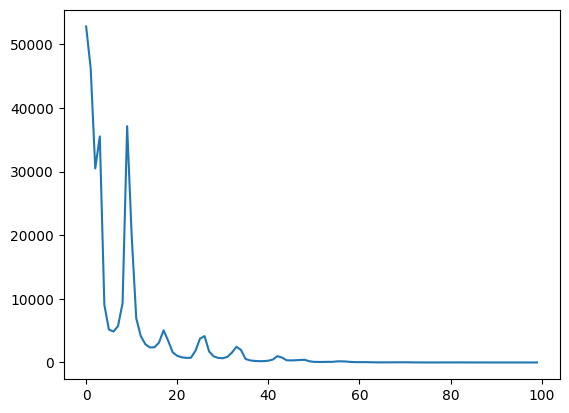

In [ ]:
%matplotlib inline
plt.plot(epoch_loss_values)

Now with test data

In [ ]:
m = 101 #number of test data

list2 = []
for i in range (1,m):
  moving0 = tifffile.imread(f'/content/test/00{i}_rt.tif')
  moving0 = np.array(moving0)
  moving0 = moving0[:, 4:148, :]
  moving0 = convert_tensor(moving0)
  moving0 = moving0.permute(0, 2, 1)
  moving = moving0.unsqueeze(0)
  moving1 = moving.unsqueeze(0)
  moving2 = moving1.to(device)
  list2.append(moving2)

In [ ]:
import timeit
start = timeit.default_timer()
activations = []
for moving2 in list2:
    ddf = net(torch.cat((moving2, fixed1), dim=1))
    #pred_image = warp_layer(moving2, ddf)
    #print(activation)
    #pred_image = pred_image.detach().cpu().numpy()[:, 0]
    activations.append(activation['fc'])

#activations[10]['fc'][0,2].item()
stop = timeit.default_timer()
print('Time: ', stop - start)

In [ ]:

predx = []
predy = []
predz = []
predrx = []
predry = []
predrz = []

for activation in activations:
  a = activation[0,3].item()
  predx.append(a)

  b = activation[0,7].item()
  predy.append(b)

  c = activation[0,11].item()
  predz.append(c)

  d = (activation[0,6].item())/(activation[0,10].item())
  d = np.arctan(d)
  predrx.append(d)

  e = activation[0,2].item()
  e = np.arcsin(-e)
  predry.append(e)

  f = (activation[0,1].item())/(activation[0,0].item())
  f = np.arctan(f)
  predrz.append(f)



<ipython-input-14-64d690a709ac>:23: RuntimeWarning: invalid value encountered in arcsin
  e = np.arcsin(-e)


In [ ]:
#translations parameters for test data
#y:
test_x = []
test_y = []
test_z = []
test_rx = []
test_ry = []
test_rz = []
for i in range(1, m):
    with open(f"/content/test/00{i}_augments.txt") as f:
        lines = f.readlines()

        line0 = lines[0]
        ry = float(line0.split("=")[1])
        #convert to radians
        ry = (ry*np.pi)/180
        test_ry.append(ry)

        line1 = lines[1]
        ty = float(line1.split("=")[1])
        test_y.append(ty)

        line2 = lines[2]
        rx = float(line2.split("=")[1])
        rx = (rx*np.pi)/180
        test_rx.append(rx)

        line3 = lines[3]
        tx = float(line3.split("=")[1])
        test_x.append(tx)

        line4 = lines[4]
        rz = float(line4.split("=")[1])
        rz = (rz*np.pi)/180 
        test_rz.append(rz)

        line5 = lines[5]
        tz = float(line5.split("=")[1])
        test_z.append(tz)

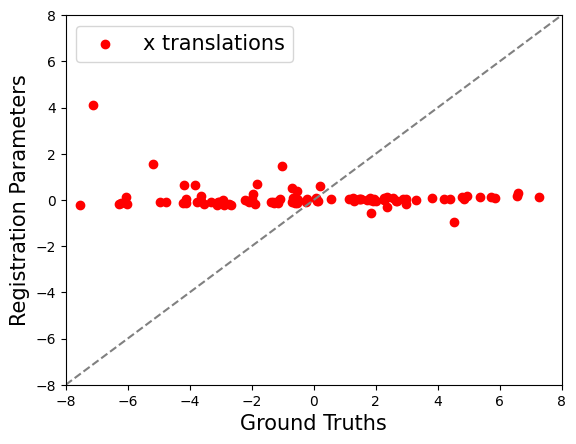

In [ ]:
%matplotlib inline
plt.scatter(test_x, predx, label="x translations", color='red')
# set the x and y axis labels
plt.xlabel("Ground Truths", fontsize = 15)
plt.ylabel("Registration Parameters", fontsize = 15)
plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.legend(fontsize=15, loc='upper left')

plt.plot([-8, 8], [-8, 8], linestyle='--', color='gray')


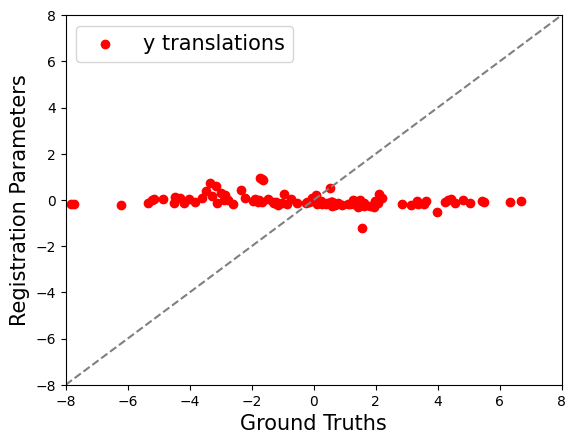

In [ ]:
%matplotlib inline
plt.scatter(test_y, predy, label="y translations", color='red')
# set the x and y axis labels
plt.xlabel("Ground Truths", fontsize = 15)
plt.ylabel("Registration Parameters", fontsize = 15)
plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.legend(fontsize=15, loc='upper left')

plt.plot([-8, 8], [-8, 8], linestyle='--', color='gray')


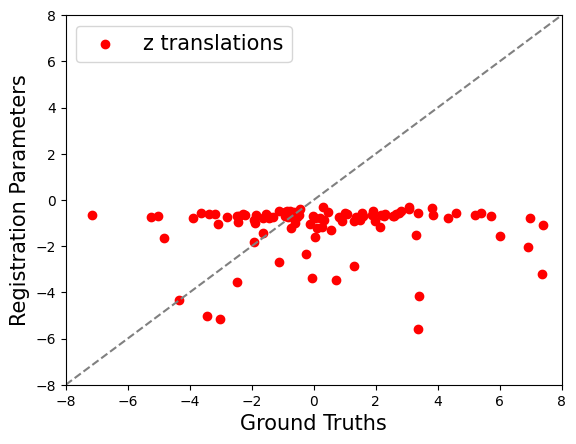

In [ ]:
%matplotlib inline
plt.scatter(test_z, predz, label="z translations", color='red')
# set the x and y axis labels
plt.xlabel("Ground Truths", fontsize = 15)
plt.ylabel("Registration Parameters", fontsize = 15)
plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.legend(fontsize=15, loc='upper left')

plt.plot([-8, 8], [-8, 8], linestyle='--', color='gray')


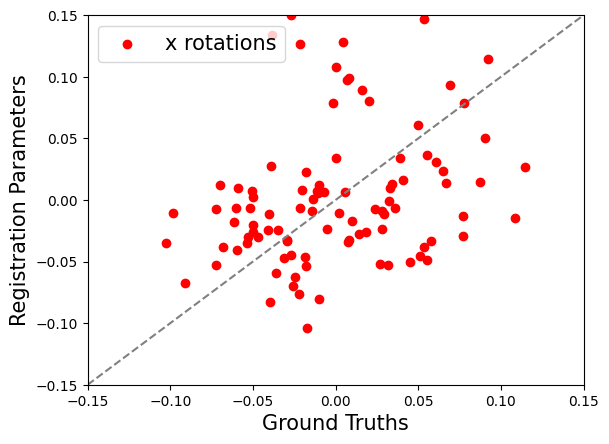

In [ ]:
%matplotlib inline
plt.scatter(test_rx, predrx, label="x rotations", color='red')
# set the x and y axis labels
plt.xlabel("Ground Truths", fontsize = 15)
plt.ylabel("Registration Parameters", fontsize = 15)
plt.xlim([-0.15, 0.15])
plt.ylim([-0.15, 0.15])
plt.legend(fontsize=15, loc='upper left')

plt.plot([-0.15, 0.15], [-0.15, 0.15], linestyle='--', color='gray')


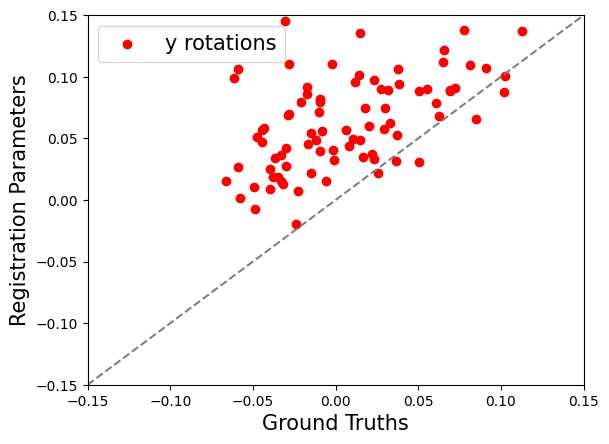

In [ ]:
%matplotlib inline
plt.scatter(test_ry, predry, label="y rotations", color='red')
# set the x and y axis labels
plt.xlabel("Ground Truths", fontsize = 15)
plt.ylabel("Registration Parameters", fontsize = 15)
plt.xlim([-0.15, 0.15])
plt.ylim([-0.15, 0.15])
plt.legend(fontsize=15, loc='upper left')

plt.plot([-0.15, 0.15], [-0.15, 0.15], linestyle='--', color='gray')


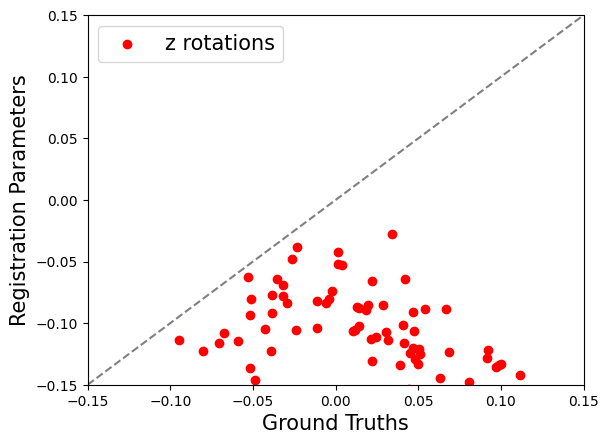

In [ ]:
%matplotlib inline
plt.scatter(test_rz, predrz, label="z rotations", color='red')
# set the x and y axis labels
plt.xlabel("Ground Truths", fontsize = 15)
plt.ylabel("Registration Parameters", fontsize = 15)
plt.xlim([-0.15, 0.15])
plt.ylim([-0.15, 0.15])
plt.legend(fontsize=15, loc='upper left')

plt.plot([-0.15, 0.15], [-0.15, 0.15], linestyle='--', color='gray')


In [ ]:
torch.save(net.state_dict(), '/content/drive/MyDrive/MRI_data/3D_07_05.pth')